# CNN & Applications

## CNN for image classification

In [88]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary

import matplotlib.pyplot as plt
from PIL import Image

In [89]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### MNIST Dataset

#### Load dataset

In [90]:
root = './../data_MNIST'
train_dataset = datasets.MNIST(
    root=root,
    train=True,
    download=True
)

test_dataset = datasets.MNIST(
    root=root,
    train=False,
    download=True
)

Train_data


In [91]:
print('shape of train data',train_dataset.data.shape)
print('class of train data: ', train_dataset.classes)
print('target of train data: ', train_dataset.targets)

shape of train data torch.Size([60000, 28, 28])
class of train data:  ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
target of train data:  tensor([5, 0, 4,  ..., 5, 6, 8])


Test_data

In [92]:
print('shape of test data',test_dataset.data.shape)
print('class of test data: ', test_dataset.classes)
print('target of test data: ', test_dataset.targets)

shape of test data torch.Size([10000, 28, 28])
class of test data:  ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
target of test data:  tensor([7, 2, 1,  ..., 4, 5, 6])


In [93]:
# plot images
def plot_images(images):
    n_images = len(images)
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range (rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i], cmap='bone')
        ax.axis('off')

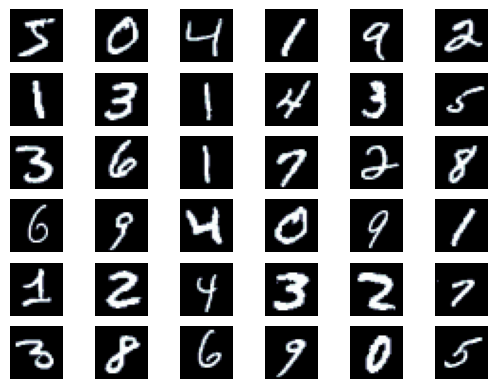

In [94]:
N_IMAGES = 36
images = [image for image, label in [train_dataset[i] for i in range(N_IMAGES)]]
plot_images(images)

#### Preprocessing


**Train: Valid = 0.8 : 0.2**

In [95]:
Valid_ratio = 0.8
n_total = len(train_dataset)
print(n_total)
n_train_examples = int(n_total * Valid_ratio)
n_valid_examples = n_total - n_train_examples
# print("n_train: ", n_train_examples)
# print("n_valid: ", n_valid_examples)

60000


In [96]:
train_data, valid_data = data.random_split(
    train_dataset, # data input
    [n_train_examples, n_valid_examples]    # sample train, valid
)
print(len(train_data))
print(len(valid_data))

48000
12000


**Preprocessing with 'transforms'**
- Normalization (mean, std)
- Convert to tensor

In [97]:
# compute mean, std
mean = train_data.dataset.data.float().mean() / 255
std = train_data.dataset.data.float().std() / 255
mean, std

(tensor(0.1307), tensor(0.3081))

In [98]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [mean], std = [std])
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [mean], std = [std])
])

In [99]:
train_data.dataset.transform = train_transforms
valid_data.dataset.transform = test_transforms

#### Dataloader

In [100]:
batch_size = 256
train_dataloader = data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=batch_size 
)

valid_dataloader = data.DataLoader(
    valid_data,
    shuffle=True,
    batch_size=batch_size 
)

In [101]:
len(train_dataloader)

188

In [102]:
next(iter(train_dataloader))[0].shape

torch.Size([256, 1, 28, 28])

In [103]:
inputs, labels = next(iter(train_dataloader))

#### Model

In [122]:
class LeNetClassifier(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding='same')
        self.avgpool2d = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu = nn.ReLU()
        
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(16*5*5, 120)
        self.dense2 = nn.Linear(120, 84)
        self.dense3 = nn.Linear(84, n_classes)
    
    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.avgpool2d(outputs)
        outputs = self.relu(outputs)
        outputs = self.conv2(outputs)
        outputs = self.avgpool2d(outputs)
        outputs = self.relu(outputs)
        outputs = self.flatten(outputs)

        outputs = self.dense1(outputs)
        outputs = self.dense2(outputs)
        outputs = self.dense3(outputs)
        return outputs
    

In [123]:
n_classes = len(train_data.dataset.classes)
n_classes

10

In [124]:
lenet_model = LeNetClassifier(n_classes)

In [125]:
lenet_model

LeNetClassifier(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (avgpool2d): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=400, out_features=120, bias=True)
  (dense2): Linear(in_features=120, out_features=84, bias=True)
  (dense3): Linear(in_features=84, out_features=10, bias=True)
)

In [126]:
predictions = lenet_model(inputs)

In [127]:
predictions.shape

torch.Size([256, 10])

#### **Loss & Optimizer**

In [128]:
optimizer = optim.Adam(lenet_model.parameters())
criterion = nn.CrossEntropyLoss()

In [131]:
loss = criterion(predictions, labels)
loss

tensor(2.3113, grad_fn=<NllLossBackward0>)

In [132]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [134]:
lenet_model.to(device)

LeNetClassifier(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (avgpool2d): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=400, out_features=120, bias=True)
  (dense2): Linear(in_features=120, out_features=84, bias=True)
  (dense3): Linear(in_features=84, out_features=10, bias=True)
)

#### Trainer

In [138]:
import time

def train(model, optimizer, criterion, train_dataloader, device, epoch = 0, log_interval = 50):
    model.train()
    total_acc, total_count =0, 0
    losses =[]
    start_time = time.time()

    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        predictions = model(inputs)

        loss = criterion(predictions, labels)
        losses.append(loss.item())


        loss.backward()
        optimizer.step()

        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)

        if i % log_interval == 0 and i > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, i, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()
    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [139]:
train_acc, train_loss = train(lenet_model, optimizer, criterion, train_dataloader, device)

| epoch   0 |    50/  188 batches | accuracy    0.699
| epoch   0 |   100/  188 batches | accuracy    0.890
| epoch   0 |   150/  188 batches | accuracy    0.916


In [140]:
train_acc, train_loss

(0.933326198630137, 0.5151019451069705)